In [ ]:
# ============================================================
# Theta-CE Drift–Diffusion Demo
# Anderson M. Rodriguez
#
# PURPOSE
#   A one-click notebook script that:
#     (1) VALIDATES drift recovery on a canonical benchmark (Ornstein–Uhlenbeck, OU),
#     (2) COMPUTES the angular order parameter θ(t) = arctan(σ̂/|μ̂|),
#     (3) SHOWS the θ coordinate on OU, a bistable system, and (optionally) CDC COVID-NET data.
#
# KEY IDEA (what θ is doing)
#   From increments Δx = x_{t+1}-x_t over a rolling window:
#     μ̂(t)  := E_window[Δx]/Δt
#     ŝ^2(t):= Var_window(Δx)/Δt
#   With the Itô–Fokker–Planck convention in 1D: D = s^2/2,
#   so σ̂(t) := sqrt(Tr(D̂)) = ŝ/√2.
#   Then:
#     θ(t) := arctan( σ̂(t) / |μ̂(t)| ) ∈ [0, π/2]
#   Interpretation: θ is a bounded, local drift–diffusion balance coordinate.
#
# OUTPUTS
#   A) OU validation scatter: μ_true(x) vs μ̂(x), plus drift correlation.
#   B) TABLE 1 (OU only): benchmark vs recovered κ, mean, and drift correlation.
#   C) TABLE 2 (all systems): θ summary statistics + v_mean + σ_mean.
#   D) Plots: signal and θ(t) for each system.
#
# DEPENDENCIES
#   numpy, pandas, matplotlib, requests (requests only needed for COVID-NET).

Reproducibility note:
This initial notebook reflects the analysis as executed for the manuscript, using COVID-NET data through the week ending January 17, 2026.
Because COVID-NET is a live surveillance feed, re-running this notebook may yield numerically different (but qualitatively equivalent) results.

This notebook is retained for inspection and correspondence with the paper.

The subsequent cell below the following script will reproduce the results of the paper.

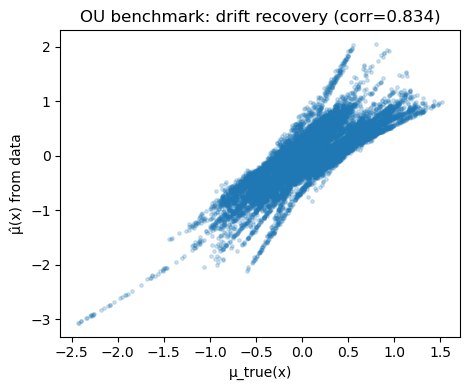

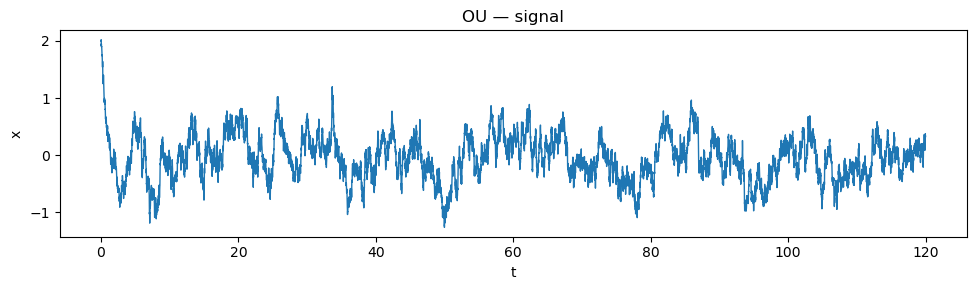

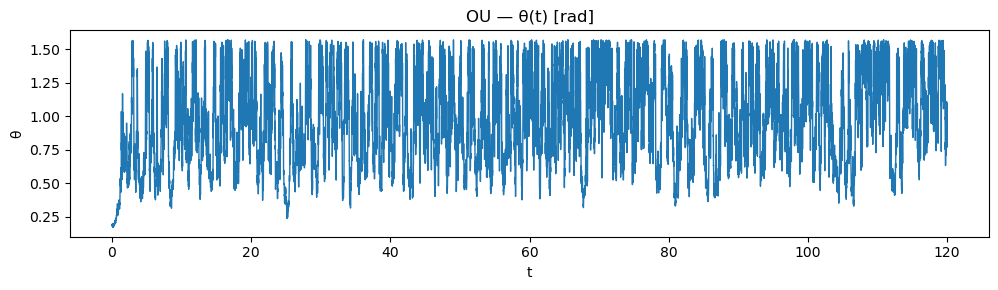

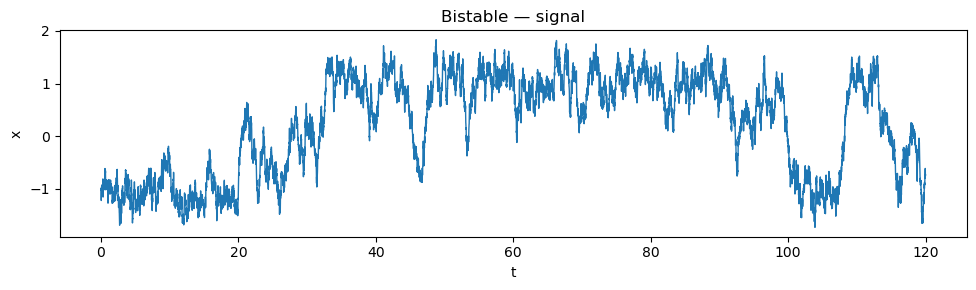

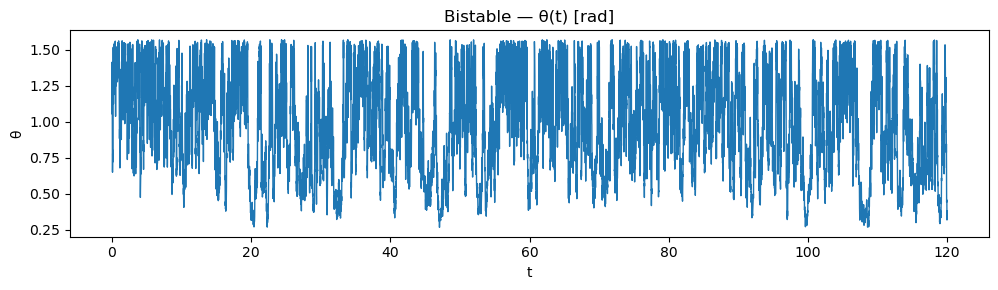

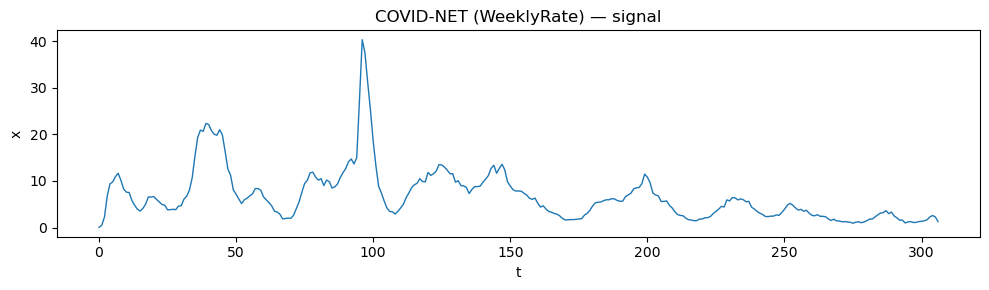

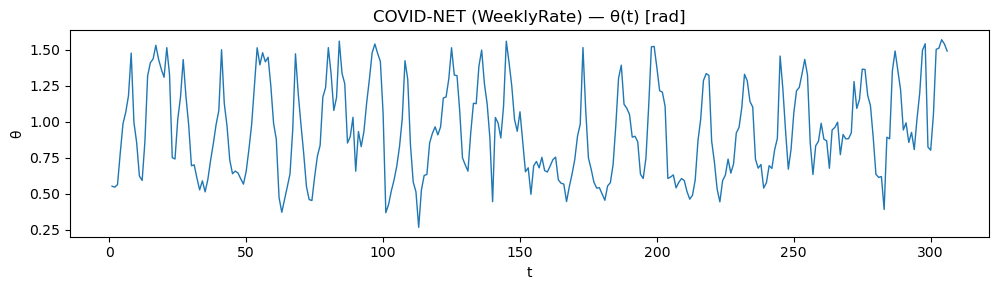


COVID-NET source: 2020-03-07 → 2026-01-17
Fields: date='_WeekendDate', value='WeeklyRate'
Rows: raw=196455  |  aggregated weekly points=307

TABLE 1 — OU validation (BENCHMARK vs RECOVERED)
 kappa_true  mean_true  kappa_hat  mean_hat  DriftCorr
      1.200      0.000      1.272    -0.046      0.834

TABLE 2 — θ summary (rad + deg) + noise-to-drift ratios
   system  theta_mean_rad  theta_mean_deg  theta_p10_rad  theta_p10_deg  theta_p90_rad  theta_p90_deg  tan_theta_mean  v_mean  sigma_mean  sigma_over_v_from_means
       OU           0.968          55.460          0.525         30.057          1.449         82.996           1.453   0.357       0.424                    1.187
 bistable           0.978          56.040          0.512         29.358          1.454         83.317           1.485   0.416       0.499                    1.199
COVID-NET           0.942          54.001          0.548         31.419          1.432         82.059           1.376   0.486       0.650                

In [5]:
# Included to view initial results, re-running will produce data through modern week
import math
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Core estimators
# ----------------------------

def theta_from_v_sigma(v, sigma, eps=1e-12):
    v = np.asarray(v, float)
    sigma = np.asarray(sigma, float)
    return np.arctan(sigma / np.maximum(v, eps))

def local_increment_estimator_1d(x, dt, window=101, center=True):
    """
    1D increment estimator (time-local):
      dx = x_{t+1}-x_t
      mu_hat(t) = E[dx]/dt
      s_hat^2(t) = Var(dx)/dt
      sigma_hat(t) = sqrt(Tr(D_hat)) = s_hat/sqrt(2) for 1D with D=s^2/2
      theta(t) = arctan(sigma_hat/|mu_hat|)
    """
    x = np.asarray(x, float)
    dx = np.diff(x)
    s = pd.Series(dx)

    min_periods = min(window, max(3, window // 3))

    mean_dx = s.rolling(window, center=center, min_periods=min_periods).mean().to_numpy()
    var_dx  = s.rolling(window, center=center, min_periods=min_periods).var(ddof=1).to_numpy()

    mu_hat = mean_dx / dt
    s_hat = np.sqrt(np.maximum(var_dx / dt, 0.0))
    sigma_hat = s_hat / math.sqrt(2.0)
    v_hat = np.abs(mu_hat)
    theta = theta_from_v_sigma(v_hat, sigma_hat)

    return pd.DataFrame({"mu": mu_hat, "v": v_hat, "sigma": sigma_hat, "theta": theta})

def rolling_linear_drift_field(x, dt, window=801, center=True):
    """
    Drift-field recovery marker:
      y = dx/dt ≈ a + b x   (rolling regression via moments)
      mu_hat(x_t) = a + b x_t
    """
    x = np.asarray(x, float)
    dx = np.diff(x)
    y = dx / dt
    X = x[:-1]

    sX, sY = pd.Series(X), pd.Series(y)
    min_periods = min(window, max(50, window // 3))

    mX = sX.rolling(window, center=center, min_periods=min_periods).mean()
    mY = sY.rolling(window, center=center, min_periods=min_periods).mean()
    vX = sX.rolling(window, center=center, min_periods=min_periods).var(ddof=1)
    covXY = (sX*sY).rolling(window, center=center, min_periods=min_periods).mean() - (mX*mY)

    b = (covXY / vX).to_numpy()
    a = (mY - (covXY / vX)*mX).to_numpy()
    mu_hat = a + b*X
    return mu_hat

def rolling_ou_exact_estimator(x, dt, window=4001, center=True):
    """
    Exact OU discrete transition:
      x_{t+dt} = c + φ x_t + noise, φ=exp(-κ dt)
      κ̂ = -(1/dt) ln φ̂, mean̂ = ĉ/(1-φ̂)
    """
    x = np.asarray(x, float)
    x0, x1 = x[:-1], x[1:]
    s0, s1 = pd.Series(x0), pd.Series(x1)

    min_periods = min(window, max(200, window // 3))

    m0 = s0.rolling(window, center=center, min_periods=min_periods).mean()
    m1 = s1.rolling(window, center=center, min_periods=min_periods).mean()
    v0 = s0.rolling(window, center=center, min_periods=min_periods).var(ddof=1)
    cov01 = (s0*s1).rolling(window, center=center, min_periods=min_periods).mean() - (m0*m1)

    phi = (cov01 / v0).to_numpy()
    phi = np.clip(phi, 1e-9, 1-1e-9)
    c = (m1 - (cov01 / v0)*m0).to_numpy()

    kappa_hat = -(1.0/dt) * np.log(phi)
    mean_hat = np.where(np.abs(1-phi) > 1e-12, c/(1-phi), np.nan)
    return float(np.nanmedian(kappa_hat)), float(np.nanmedian(mean_hat))

def summarize_theta(est):
    th = est["theta"].to_numpy()
    v  = est["v"].to_numpy()
    sg = est["sigma"].to_numpy()
    finite = np.isfinite(th)
    th, v, sg = th[finite], v[finite], sg[finite]

    th_mean = float(np.mean(th))
    th_p10  = float(np.percentile(th, 10))
    th_p90  = float(np.percentile(th, 90))

    out = {
        "theta_mean_rad": th_mean,
        "theta_p10_rad": th_p10,
        "theta_p90_rad": th_p90,
        "theta_mean_deg": th_mean * 180/np.pi,
        "theta_p10_deg": th_p10 * 180/np.pi,
        "theta_p90_deg": th_p90 * 180/np.pi,
        "tan_theta_mean": float(np.tan(th_mean)),
        "v_mean": float(np.mean(v)),
        "sigma_mean": float(np.mean(sg)),
        "sigma_over_v_from_means": float(np.mean(sg)) / max(float(np.mean(v)), 1e-12),
    }
    return out

# ----------------------------
# Simulators
# ----------------------------

def simulate_ou(n_steps=12000, dt=0.01, kappa=1.2, mean=0.0, s=0.6, x0=2.0, seed=1):
    rng = np.random.default_rng(seed)
    t = np.arange(n_steps+1) * dt
    x = np.zeros(n_steps+1, float)
    x[0] = x0
    for i in range(n_steps):
        dW = rng.normal(0.0, math.sqrt(dt))
        mu = -kappa*(x[i]-mean)
        x[i+1] = x[i] + mu*dt + s*dW
    return t, x

def simulate_bistable(n_steps=12000, dt=0.01, a=1.0, b=1.0, s=0.7, x0=-1.0, seed=2):
    rng = np.random.default_rng(seed)
    t = np.arange(n_steps+1) * dt
    x = np.zeros(n_steps+1, float)
    x[0] = x0
    for i in range(n_steps):
        dW = rng.normal(0.0, math.sqrt(dt))
        mu = (b*x[i] - a*(x[i]**3))
        x[i+1] = x[i] + mu*dt + s*dW
    return t, x

# ----------------------------
# COVID-NET fetch + robust weekly aggregation
# ----------------------------

def fetch_covidnet_weekly_series(asset_id="6jg4-xsqq", timeout=30):
    import requests
    url = f"https://data.cdc.gov/api/views/{asset_id}/rows.csv"
    r = requests.get(url, params={"accessType": "DOWNLOAD"}, timeout=timeout)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text))

    # infer columns
    cols = list(df.columns)
    low = {c: str(c).lower() for c in cols}

    date_col = None
    for c in cols:
        lc = low[c]
        if "week" in lc and "date" in lc and ("end" in lc or "ending" in lc):
            date_col = c
            break
    if date_col is None:
        date_col = next((c for c in cols if "date" in low[c]), None)

    value_col = next((c for c in cols if ("rate" in low[c] and "pop" not in low[c])), None)
    if date_col is None or value_col is None:
        raise RuntimeError(f"Could not infer columns (date={date_col}, value={value_col}).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[date_col, value_col])

    # If there are multiple rows per week (e.g., by site/age strata),
    # aggregate to a single national weekly series by mean per date.
    # (This prevents gigantic n and makes dt=1 week meaningful.)
    series = df.groupby(date_col)[value_col].mean().sort_index()

    dates = series.index.to_numpy()
    x = series.to_numpy(float)
    return dates, x, date_col, value_col, len(df), len(series)

# ----------------------------
# Minimal plotting
# ----------------------------

def plot_signal_theta(title, t, x, est):
    plt.figure(figsize=(10,3.0))
    plt.plot(t, x, lw=1.0)
    plt.title(f"{title} — signal")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,3.0))
    plt.plot(t[1:], est["theta"].to_numpy(), lw=1.0)
    plt.title(f"{title} — θ(t) [rad]")
    plt.xlabel("t")
    plt.ylabel("θ")
    plt.tight_layout()
    plt.show()

# ============================================================
# RUN (OU benchmark + θ summaries)
# ============================================================

theta_rows = []

# ---- OU (benchmark + validation) ----
OU = dict(n_steps=12000, dt=0.01, kappa=1.2, mean=0.0, s=0.6, x0=2.0, seed=1)
t_ou, x_ou = simulate_ou(**OU)

est_ou = local_increment_estimator_1d(x_ou, dt=OU["dt"], window=101)
theta_rows.append({"system":"OU", **summarize_theta(est_ou)})

mu_true = -OU["kappa"]*(x_ou[:-1]-OU["mean"])
mu_hat = rolling_linear_drift_field(x_ou, dt=OU["dt"], window=801)
finite = np.isfinite(mu_hat)
drift_corr = float(np.corrcoef(mu_true[finite], mu_hat[finite])[0,1])

kappa_hat, mean_hat = rolling_ou_exact_estimator(x_ou, dt=OU["dt"], window=4001)

# OU drift scatter: benchmark vs recovered
plt.figure(figsize=(4.8,4.0))
plt.scatter(mu_true[finite], mu_hat[finite], s=6, alpha=0.20)
plt.xlabel("μ_true(x)")
plt.ylabel("μ̂(x) from data")
plt.title(f"OU benchmark: drift recovery (corr={drift_corr:.3f})")
plt.tight_layout()
plt.show()

plot_signal_theta("OU", t_ou, x_ou, est_ou)

# ---- Bistable (θ only) ----
t_bi, x_bi = simulate_bistable()
est_bi = local_increment_estimator_1d(x_bi, dt=0.01, window=101)
theta_rows.append({"system":"bistable", **summarize_theta(est_bi)})
plot_signal_theta("Bistable", t_bi, x_bi, est_bi)

# ---- COVID-NET (θ only, aggregated weekly) ----
RUN_COVIDNET = True
if RUN_COVIDNET:
    try:
        dates, x_c, date_col, value_col, n_raw, n_week = fetch_covidnet_weekly_series()
        est_c = local_increment_estimator_1d(x_c, dt=1.0, window=9)  # dt=1 week after aggregation
        theta_rows.append({"system":"COVID-NET", **summarize_theta(est_c)})

        t_c = np.arange(len(x_c), dtype=float)
        plot_signal_theta(f"COVID-NET ({value_col})", t_c, x_c, est_c)

        print(f"\nCOVID-NET source: {pd.to_datetime(dates[0]).date()} → {pd.to_datetime(dates[-1]).date()}")
        print(f"Fields: date='{date_col}', value='{value_col}'")
        print(f"Rows: raw={n_raw}  |  aggregated weekly points={n_week}")
    except Exception as e:
        print("\nCOVID-NET skipped (non-fatal). Reason:", repr(e))

# ============================================================
# PRINT TABLES (clear + with degrees)
# ============================================================

# Table 1: OU validation only
ou_validation = pd.DataFrame([{
    "kappa_true": OU["kappa"],
    "mean_true": OU["mean"],
    "kappa_hat": kappa_hat,
    "mean_hat": mean_hat,
    "DriftCorr": drift_corr
}])

# Table 2: θ summary (rad + deg + ratios)
theta_df = pd.DataFrame(theta_rows)[[
    "system",
    "theta_mean_rad","theta_mean_deg",
    "theta_p10_rad","theta_p10_deg",
    "theta_p90_rad","theta_p90_deg",
    "tan_theta_mean",
    "v_mean","sigma_mean","sigma_over_v_from_means"
]]

with pd.option_context("display.width", 200, "display.float_format", "{:.3f}".format):
    print("\nTABLE 1 — OU validation (BENCHMARK vs RECOVERED)")
    print(ou_validation.to_string(index=False))

    print("\nTABLE 2 — θ summary (rad + deg) + noise-to-drift ratios")
    print(theta_df.to_string(index=False))

print("\nOne-line interpretation per system:")
for _, r in theta_df.iterrows():
    print(f"  {r['system']}: θ̄ = {r['theta_mean_deg']:.1f}°  ⇒  σ/|μ| ≈ {r['tan_theta_mean']:.2f} (mean-angle),  or ≈ {r['sigma_over_v_from_means']:.2f} (ratio-of-means)")


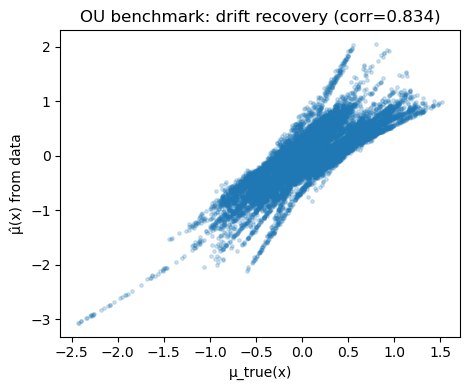

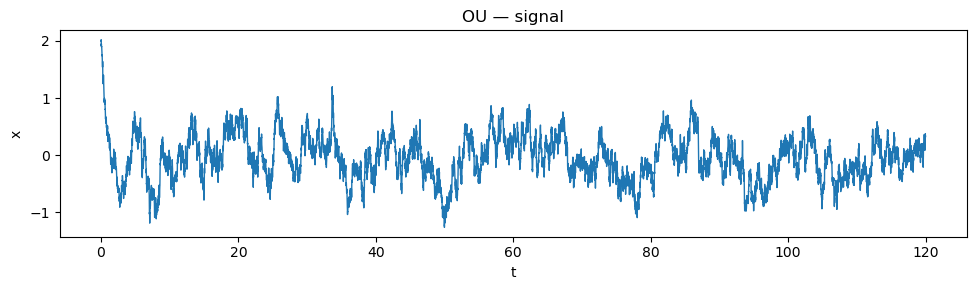

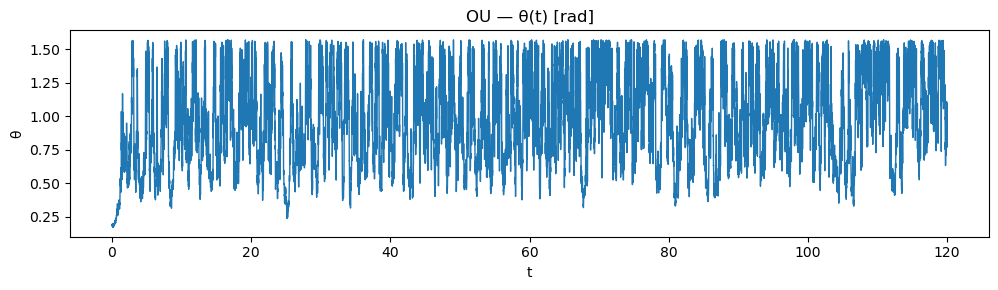

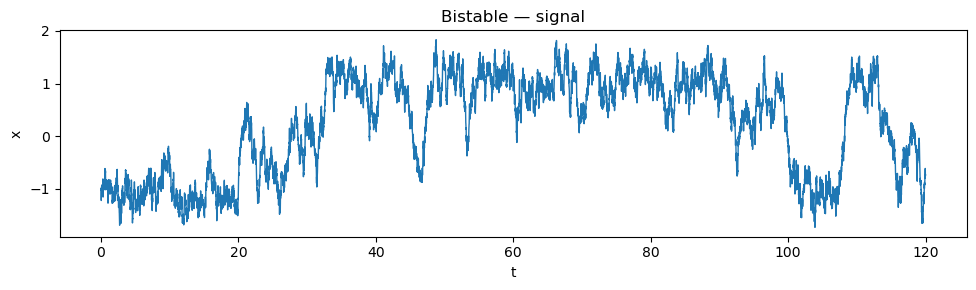

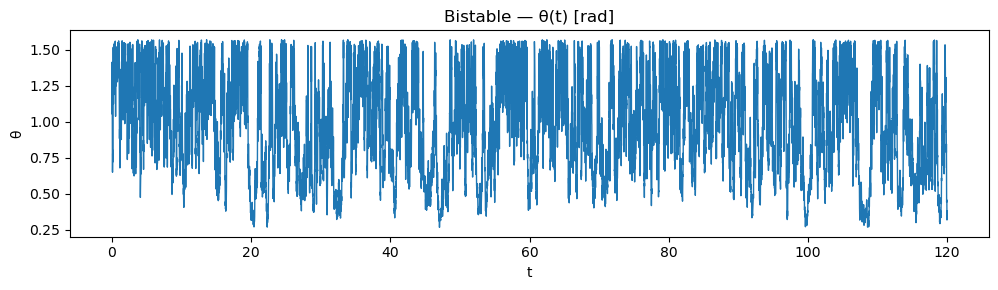

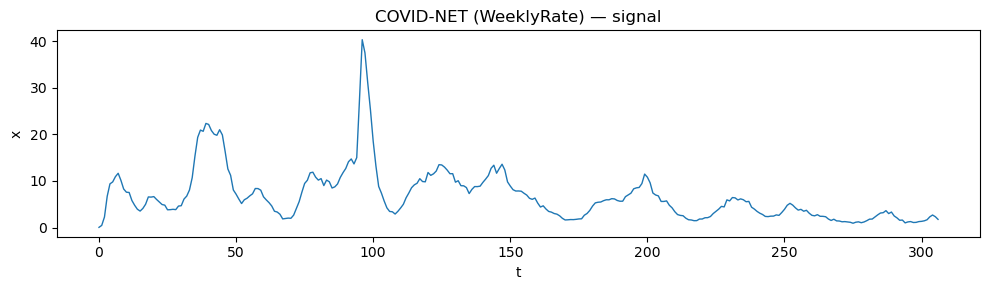

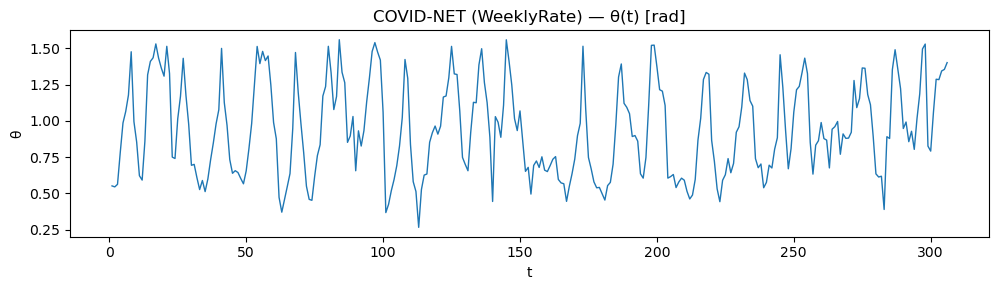


COVID-NET source: 2020-03-07 → 2026-01-17
Fields: date='_WeekendDate', value='WeeklyRate'
Rows: raw=197120  |  aggregated weekly points=307

TABLE 1 — OU validation (BENCHMARK vs RECOVERED)
 kappa_true  mean_true  kappa_hat  mean_hat  DriftCorr
      1.200      0.000      1.272    -0.046      0.834

TABLE 2 — θ summary (rad + deg) + noise-to-drift ratios
   system  theta_mean_rad  theta_mean_deg  theta_p10_rad  theta_p10_deg  theta_p90_rad  theta_p90_deg  tan_theta_mean  v_mean  sigma_mean  sigma_over_v_from_means
       OU           0.968          55.460          0.525         30.057          1.449         82.996           1.453   0.357       0.424                    1.187
 bistable           0.978          56.040          0.512         29.358          1.454         83.317           1.485   0.416       0.499                    1.199
COVID-NET           0.939          53.818          0.548         31.419          1.411         80.848           1.367   0.487       0.649                

In [4]:
# This script's data retrival is truncated at the week of 1-17-2026
# This will appropriately reproduce the results of the paper.
# The following cells fetch the current COVID-NET dataset and recompute θ.
#
#
# Note: Results may differ slightly from those reported in the manuscript 
# due to retrospective data updates.
#
import math
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Core estimators
# ----------------------------

def theta_from_v_sigma(v, sigma, eps=1e-12):
    v = np.asarray(v, float)
    sigma = np.asarray(sigma, float)
    return np.arctan(sigma / np.maximum(v, eps))

def local_increment_estimator_1d(x, dt, window=101, center=True):
    """
    1D increment estimator (time-local):
      dx = x_{t+1}-x_t
      mu_hat(t) = E[dx]/dt
      s_hat^2(t) = Var(dx)/dt
      sigma_hat(t) = sqrt(Tr(D_hat)) = s_hat/sqrt(2) for 1D with D=s^2/2
      theta(t) = arctan(sigma_hat/|mu_hat|)
    """
    x = np.asarray(x, float)
    dx = np.diff(x)
    s = pd.Series(dx)

    min_periods = min(window, max(3, window // 3))

    mean_dx = s.rolling(window, center=center, min_periods=min_periods).mean().to_numpy()
    var_dx  = s.rolling(window, center=center, min_periods=min_periods).var(ddof=1).to_numpy()

    mu_hat = mean_dx / dt
    s_hat = np.sqrt(np.maximum(var_dx / dt, 0.0))
    sigma_hat = s_hat / math.sqrt(2.0)
    v_hat = np.abs(mu_hat)
    theta = theta_from_v_sigma(v_hat, sigma_hat)

    return pd.DataFrame({"mu": mu_hat, "v": v_hat, "sigma": sigma_hat, "theta": theta})

def rolling_linear_drift_field(x, dt, window=801, center=True):
    """
    Drift-field recovery marker:
      y = dx/dt ≈ a + b x   (rolling regression via moments)
      mu_hat(x_t) = a + b x_t
    """
    x = np.asarray(x, float)
    dx = np.diff(x)
    y = dx / dt
    X = x[:-1]

    sX, sY = pd.Series(X), pd.Series(y)
    min_periods = min(window, max(50, window // 3))

    mX = sX.rolling(window, center=center, min_periods=min_periods).mean()
    mY = sY.rolling(window, center=center, min_periods=min_periods).mean()
    vX = sX.rolling(window, center=center, min_periods=min_periods).var(ddof=1)
    covXY = (sX*sY).rolling(window, center=center, min_periods=min_periods).mean() - (mX*mY)

    b = (covXY / vX).to_numpy()
    a = (mY - (covXY / vX)*mX).to_numpy()
    mu_hat = a + b*X
    return mu_hat

def rolling_ou_exact_estimator(x, dt, window=4001, center=True):
    """
    Exact OU discrete transition:
      x_{t+dt} = c + φ x_t + noise, φ=exp(-κ dt)
      κ̂ = -(1/dt) ln φ̂, mean̂ = ĉ/(1-φ̂)
    """
    x = np.asarray(x, float)
    x0, x1 = x[:-1], x[1:]
    s0, s1 = pd.Series(x0), pd.Series(x1)

    min_periods = min(window, max(200, window // 3))

    m0 = s0.rolling(window, center=center, min_periods=min_periods).mean()
    m1 = s1.rolling(window, center=center, min_periods=min_periods).mean()
    v0 = s0.rolling(window, center=center, min_periods=min_periods).var(ddof=1)
    cov01 = (s0*s1).rolling(window, center=center, min_periods=min_periods).mean() - (m0*m1)

    phi = (cov01 / v0).to_numpy()
    phi = np.clip(phi, 1e-9, 1-1e-9)
    c = (m1 - (cov01 / v0)*m0).to_numpy()

    kappa_hat = -(1.0/dt) * np.log(phi)
    mean_hat = np.where(np.abs(1-phi) > 1e-12, c/(1-phi), np.nan)
    return float(np.nanmedian(kappa_hat)), float(np.nanmedian(mean_hat))

def summarize_theta(est):
    th = est["theta"].to_numpy()
    v  = est["v"].to_numpy()
    sg = est["sigma"].to_numpy()
    finite = np.isfinite(th)
    th, v, sg = th[finite], v[finite], sg[finite]

    th_mean = float(np.mean(th))
    th_p10  = float(np.percentile(th, 10))
    th_p90  = float(np.percentile(th, 90))

    out = {
        "theta_mean_rad": th_mean,
        "theta_p10_rad": th_p10,
        "theta_p90_rad": th_p90,
        "theta_mean_deg": th_mean * 180/np.pi,
        "theta_p10_deg": th_p10 * 180/np.pi,
        "theta_p90_deg": th_p90 * 180/np.pi,
        "tan_theta_mean": float(np.tan(th_mean)),
        "v_mean": float(np.mean(v)),
        "sigma_mean": float(np.mean(sg)),
        "sigma_over_v_from_means": float(np.mean(sg)) / max(float(np.mean(v)), 1e-12),
    }
    return out

# ----------------------------
# Simulators
# ----------------------------

def simulate_ou(n_steps=12000, dt=0.01, kappa=1.2, mean=0.0, s=0.6, x0=2.0, seed=1):
    rng = np.random.default_rng(seed)
    t = np.arange(n_steps+1) * dt
    x = np.zeros(n_steps+1, float)
    x[0] = x0
    for i in range(n_steps):
        dW = rng.normal(0.0, math.sqrt(dt))
        mu = -kappa*(x[i]-mean)
        x[i+1] = x[i] + mu*dt + s*dW
    return t, x

def simulate_bistable(n_steps=12000, dt=0.01, a=1.0, b=1.0, s=0.7, x0=-1.0, seed=2):
    rng = np.random.default_rng(seed)
    t = np.arange(n_steps+1) * dt
    x = np.zeros(n_steps+1, float)
    x[0] = x0
    for i in range(n_steps):
        dW = rng.normal(0.0, math.sqrt(dt))
        mu = (b*x[i] - a*(x[i]**3))
        x[i+1] = x[i] + mu*dt + s*dW
    return t, x

# ----------------------------
# COVID-NET fetch + robust weekly aggregation
# ----------------------------

def fetch_covidnet_weekly_series(asset_id="6jg4-xsqq", timeout=30):
    import requests
    url = f"https://data.cdc.gov/api/views/{asset_id}/rows.csv"
    r = requests.get(url, params={"accessType": "DOWNLOAD"}, timeout=timeout)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text))

    # infer columns
    cols = list(df.columns)
    low = {c: str(c).lower() for c in cols}

    date_col = None
    for c in cols:
        lc = low[c]
        if "week" in lc and "date" in lc and ("end" in lc or "ending" in lc):
            date_col = c
            break
    if date_col is None:
        date_col = next((c for c in cols if "date" in low[c]), None)

    value_col = next((c for c in cols if ("rate" in low[c] and "pop" not in low[c])), None)
    if date_col is None or value_col is None:
        raise RuntimeError(f"Could not infer columns (date={date_col}, value={value_col}).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[date_col, value_col])

    # If there are multiple rows per week (e.g., by site/age strata),
    # aggregate to a single national weekly series by mean per date.
    # (This prevents gigantic n and makes dt=1 week meaningful.)
    series = df.groupby(date_col)[value_col].mean().sort_index()
    series = series.loc[: "2026-01-17"]


    dates = series.index.to_numpy()
    x = series.to_numpy(float)
    return dates, x, date_col, value_col, len(df), len(series)

# ----------------------------
# Minimal plotting
# ----------------------------

def plot_signal_theta(title, t, x, est):
    plt.figure(figsize=(10,3.0))
    plt.plot(t, x, lw=1.0)
    plt.title(f"{title} — signal")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,3.0))
    plt.plot(t[1:], est["theta"].to_numpy(), lw=1.0)
    plt.title(f"{title} — θ(t) [rad]")
    plt.xlabel("t")
    plt.ylabel("θ")
    plt.tight_layout()
    plt.show()

# ============================================================
# RUN (OU benchmark + θ summaries)
# ============================================================

theta_rows = []

# ---- OU (benchmark + validation) ----
OU = dict(n_steps=12000, dt=0.01, kappa=1.2, mean=0.0, s=0.6, x0=2.0, seed=1)
t_ou, x_ou = simulate_ou(**OU)

est_ou = local_increment_estimator_1d(x_ou, dt=OU["dt"], window=101)
theta_rows.append({"system":"OU", **summarize_theta(est_ou)})

mu_true = -OU["kappa"]*(x_ou[:-1]-OU["mean"])
mu_hat = rolling_linear_drift_field(x_ou, dt=OU["dt"], window=801)
finite = np.isfinite(mu_hat)
drift_corr = float(np.corrcoef(mu_true[finite], mu_hat[finite])[0,1])

kappa_hat, mean_hat = rolling_ou_exact_estimator(x_ou, dt=OU["dt"], window=4001)

# OU drift scatter: benchmark vs recovered
plt.figure(figsize=(4.8,4.0))
plt.scatter(mu_true[finite], mu_hat[finite], s=6, alpha=0.20)
plt.xlabel("μ_true(x)")
plt.ylabel("μ̂(x) from data")
plt.title(f"OU benchmark: drift recovery (corr={drift_corr:.3f})")
plt.tight_layout()
plt.show()

plot_signal_theta("OU", t_ou, x_ou, est_ou)

# ---- Bistable (θ only) ----
t_bi, x_bi = simulate_bistable()
est_bi = local_increment_estimator_1d(x_bi, dt=0.01, window=101)
theta_rows.append({"system":"bistable", **summarize_theta(est_bi)})
plot_signal_theta("Bistable", t_bi, x_bi, est_bi)

# ---- COVID-NET (θ only, aggregated weekly) ----
RUN_COVIDNET = True
if RUN_COVIDNET:
    try:
        dates, x_c, date_col, value_col, n_raw, n_week = fetch_covidnet_weekly_series()
        est_c = local_increment_estimator_1d(x_c, dt=1.0, window=9)  # dt=1 week after aggregation
        theta_rows.append({"system":"COVID-NET", **summarize_theta(est_c)})

        t_c = np.arange(len(x_c), dtype=float)
        plot_signal_theta(f"COVID-NET ({value_col})", t_c, x_c, est_c)

        print(f"\nCOVID-NET source: {pd.to_datetime(dates[0]).date()} → {pd.to_datetime(dates[-1]).date()}")
        print(f"Fields: date='{date_col}', value='{value_col}'")
        print(f"Rows: raw={n_raw}  |  aggregated weekly points={n_week}")
    except Exception as e:
        print("\nCOVID-NET skipped (non-fatal). Reason:", repr(e))

# ============================================================
# PRINT TABLES (clear + with degrees)
# ============================================================

# Table 1: OU validation only
ou_validation = pd.DataFrame([{
    "kappa_true": OU["kappa"],
    "mean_true": OU["mean"],
    "kappa_hat": kappa_hat,
    "mean_hat": mean_hat,
    "DriftCorr": drift_corr
}])

# Table 2: θ summary (rad + deg + ratios)
theta_df = pd.DataFrame(theta_rows)[[
    "system",
    "theta_mean_rad","theta_mean_deg",
    "theta_p10_rad","theta_p10_deg",
    "theta_p90_rad","theta_p90_deg",
    "tan_theta_mean",
    "v_mean","sigma_mean","sigma_over_v_from_means"
]]

with pd.option_context("display.width", 200, "display.float_format", "{:.3f}".format):
    print("\nTABLE 1 — OU validation (BENCHMARK vs RECOVERED)")
    print(ou_validation.to_string(index=False))

    print("\nTABLE 2 — θ summary (rad + deg) + noise-to-drift ratios")
    print(theta_df.to_string(index=False))

print("\nOne-line interpretation per system:")
for _, r in theta_df.iterrows():
    print(f"  {r['system']}: θ̄ = {r['theta_mean_deg']:.1f}°  ⇒  σ/|μ| ≈ {r['tan_theta_mean']:.2f} (mean-angle),  or ≈ {r['sigma_over_v_from_means']:.2f} (ratio-of-means)")


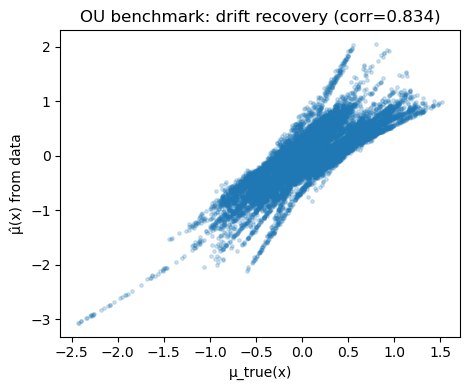

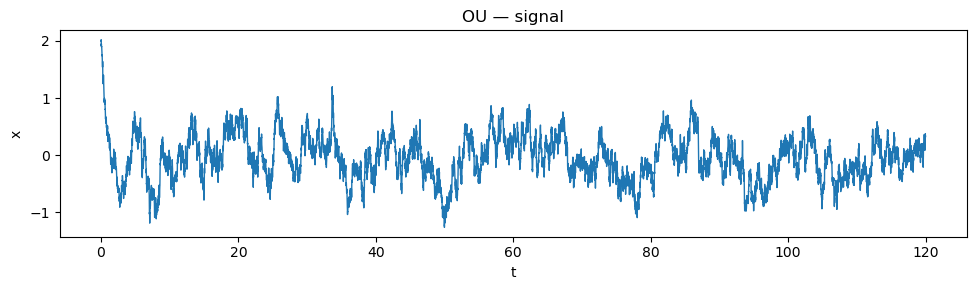

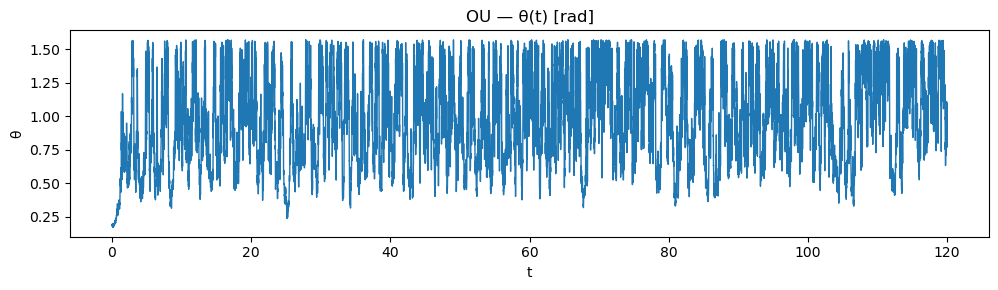

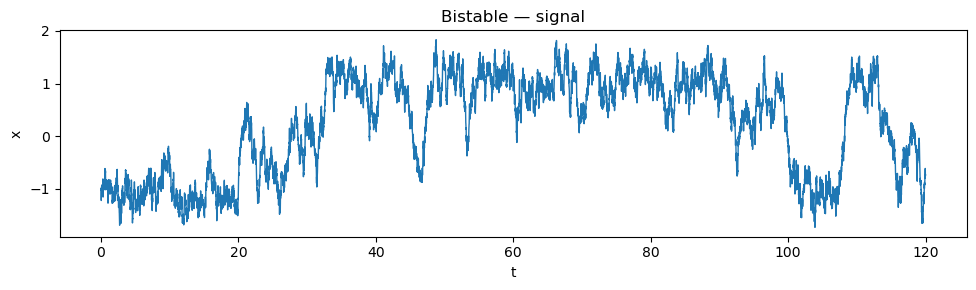

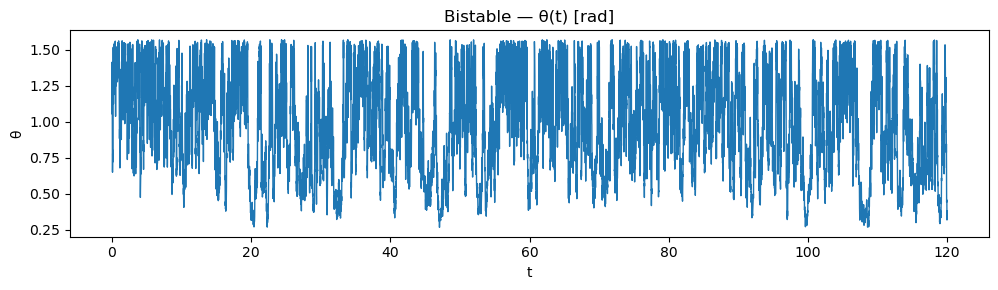

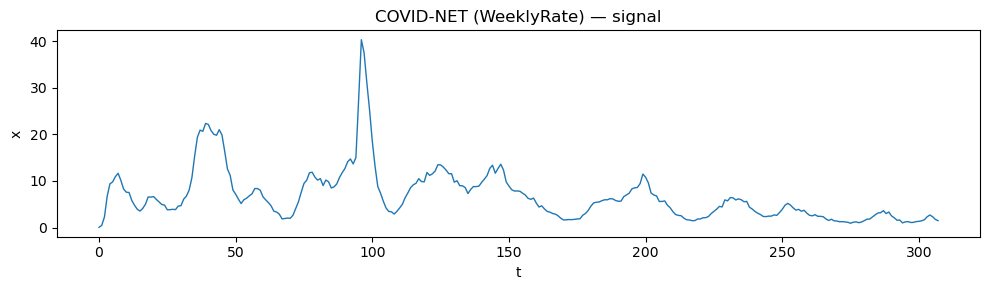

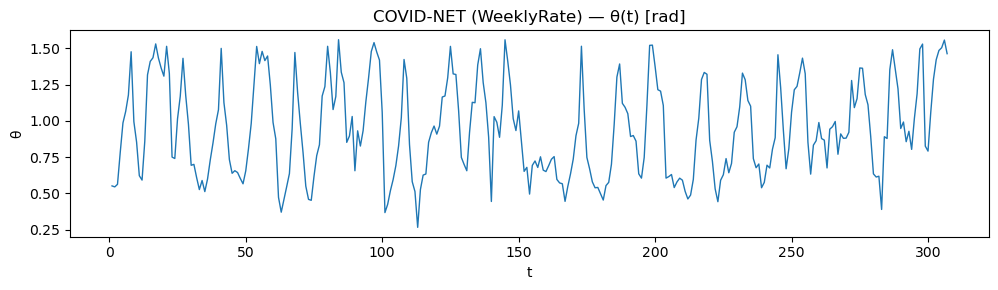


COVID-NET source: 2020-03-07 → 2026-01-24
Fields: date='_WeekendDate', value='WeeklyRate'
Rows: raw=197120  |  aggregated weekly points=308

TABLE 1 — OU validation (BENCHMARK vs RECOVERED)
 kappa_true  mean_true  kappa_hat  mean_hat  DriftCorr
      1.200      0.000      1.272    -0.046      0.834

TABLE 2 — θ summary (rad + deg) + noise-to-drift ratios
   system  theta_mean_rad  theta_mean_deg  theta_p10_rad  theta_p10_deg  theta_p90_rad  theta_p90_deg  tan_theta_mean  v_mean  sigma_mean  sigma_over_v_from_means
       OU           0.968          55.460          0.525         30.057          1.449         82.996           1.453   0.357       0.424                    1.187
 bistable           0.978          56.040          0.512         29.358          1.454         83.317           1.485   0.416       0.499                    1.199
COVID-NET           0.943          54.025          0.549         31.436          1.427         81.743           1.378   0.485       0.648                

In [10]:
# This iteration will run 'modern' COVID-NET data,
# i.e., this runs the script with up-to-date data.
#
import math
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Core estimators
# ----------------------------

def theta_from_v_sigma(v, sigma, eps=1e-12):
    v = np.asarray(v, float)
    sigma = np.asarray(sigma, float)
    return np.arctan(sigma / np.maximum(v, eps))

def local_increment_estimator_1d(x, dt, window=101, center=True):
    """
    1D increment estimator (time-local):
      dx = x_{t+1}-x_t
      mu_hat(t) = E[dx]/dt
      s_hat^2(t) = Var(dx)/dt
      sigma_hat(t) = sqrt(Tr(D_hat)) = s_hat/sqrt(2) for 1D with D=s^2/2
      theta(t) = arctan(sigma_hat/|mu_hat|)
    """
    x = np.asarray(x, float)
    dx = np.diff(x)
    s = pd.Series(dx)

    min_periods = min(window, max(3, window // 3))

    mean_dx = s.rolling(window, center=center, min_periods=min_periods).mean().to_numpy()
    var_dx  = s.rolling(window, center=center, min_periods=min_periods).var(ddof=1).to_numpy()

    mu_hat = mean_dx / dt
    s_hat = np.sqrt(np.maximum(var_dx / dt, 0.0))
    sigma_hat = s_hat / math.sqrt(2.0)
    v_hat = np.abs(mu_hat)
    theta = theta_from_v_sigma(v_hat, sigma_hat)

    return pd.DataFrame({"mu": mu_hat, "v": v_hat, "sigma": sigma_hat, "theta": theta})

def rolling_linear_drift_field(x, dt, window=801, center=True):
    """
    Drift-field recovery marker:
      y = dx/dt ≈ a + b x   (rolling regression via moments)
      mu_hat(x_t) = a + b x_t
    """
    x = np.asarray(x, float)
    dx = np.diff(x)
    y = dx / dt
    X = x[:-1]

    sX, sY = pd.Series(X), pd.Series(y)
    min_periods = min(window, max(50, window // 3))

    mX = sX.rolling(window, center=center, min_periods=min_periods).mean()
    mY = sY.rolling(window, center=center, min_periods=min_periods).mean()
    vX = sX.rolling(window, center=center, min_periods=min_periods).var(ddof=1)
    covXY = (sX*sY).rolling(window, center=center, min_periods=min_periods).mean() - (mX*mY)

    b = (covXY / vX).to_numpy()
    a = (mY - (covXY / vX)*mX).to_numpy()
    mu_hat = a + b*X
    return mu_hat

def rolling_ou_exact_estimator(x, dt, window=4001, center=True):
    """
    Exact OU discrete transition:
      x_{t+dt} = c + φ x_t + noise, φ=exp(-κ dt)
      κ̂ = -(1/dt) ln φ̂, mean̂ = ĉ/(1-φ̂)
    """
    x = np.asarray(x, float)
    x0, x1 = x[:-1], x[1:]
    s0, s1 = pd.Series(x0), pd.Series(x1)

    min_periods = min(window, max(200, window // 3))

    m0 = s0.rolling(window, center=center, min_periods=min_periods).mean()
    m1 = s1.rolling(window, center=center, min_periods=min_periods).mean()
    v0 = s0.rolling(window, center=center, min_periods=min_periods).var(ddof=1)
    cov01 = (s0*s1).rolling(window, center=center, min_periods=min_periods).mean() - (m0*m1)

    phi = (cov01 / v0).to_numpy()
    phi = np.clip(phi, 1e-9, 1-1e-9)
    c = (m1 - (cov01 / v0)*m0).to_numpy()

    kappa_hat = -(1.0/dt) * np.log(phi)
    mean_hat = np.where(np.abs(1-phi) > 1e-12, c/(1-phi), np.nan)
    return float(np.nanmedian(kappa_hat)), float(np.nanmedian(mean_hat))

def summarize_theta(est):
    th = est["theta"].to_numpy()
    v  = est["v"].to_numpy()
    sg = est["sigma"].to_numpy()
    finite = np.isfinite(th)
    th, v, sg = th[finite], v[finite], sg[finite]

    th_mean = float(np.mean(th))
    th_p10  = float(np.percentile(th, 10))
    th_p90  = float(np.percentile(th, 90))

    out = {
        "theta_mean_rad": th_mean,
        "theta_p10_rad": th_p10,
        "theta_p90_rad": th_p90,
        "theta_mean_deg": th_mean * 180/np.pi,
        "theta_p10_deg": th_p10 * 180/np.pi,
        "theta_p90_deg": th_p90 * 180/np.pi,
        "tan_theta_mean": float(np.tan(th_mean)),
        "v_mean": float(np.mean(v)),
        "sigma_mean": float(np.mean(sg)),
        "sigma_over_v_from_means": float(np.mean(sg)) / max(float(np.mean(v)), 1e-12),
    }
    return out

# ----------------------------
# Simulators
# ----------------------------

def simulate_ou(n_steps=12000, dt=0.01, kappa=1.2, mean=0.0, s=0.6, x0=2.0, seed=1):
    rng = np.random.default_rng(seed)
    t = np.arange(n_steps+1) * dt
    x = np.zeros(n_steps+1, float)
    x[0] = x0
    for i in range(n_steps):
        dW = rng.normal(0.0, math.sqrt(dt))
        mu = -kappa*(x[i]-mean)
        x[i+1] = x[i] + mu*dt + s*dW
    return t, x

def simulate_bistable(n_steps=12000, dt=0.01, a=1.0, b=1.0, s=0.7, x0=-1.0, seed=2):
    rng = np.random.default_rng(seed)
    t = np.arange(n_steps+1) * dt
    x = np.zeros(n_steps+1, float)
    x[0] = x0
    for i in range(n_steps):
        dW = rng.normal(0.0, math.sqrt(dt))
        mu = (b*x[i] - a*(x[i]**3))
        x[i+1] = x[i] + mu*dt + s*dW
    return t, x

# ----------------------------
# COVID-NET fetch + robust weekly aggregation
# ----------------------------

def fetch_covidnet_weekly_series(asset_id="6jg4-xsqq", timeout=30):
    import requests
    url = f"https://data.cdc.gov/api/views/{asset_id}/rows.csv"
    r = requests.get(url, params={"accessType": "DOWNLOAD"}, timeout=timeout)
    r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text))

    # infer columns
    cols = list(df.columns)
    low = {c: str(c).lower() for c in cols}

    date_col = None
    for c in cols:
        lc = low[c]
        if "week" in lc and "date" in lc and ("end" in lc or "ending" in lc):
            date_col = c
            break
    if date_col is None:
        date_col = next((c for c in cols if "date" in low[c]), None)

    value_col = next((c for c in cols if ("rate" in low[c] and "pop" not in low[c])), None)
    if date_col is None or value_col is None:
        raise RuntimeError(f"Could not infer columns (date={date_col}, value={value_col}).")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[date_col, value_col])

    # If there are multiple rows per week (e.g., by site/age strata),
    # aggregate to a single national weekly series by mean per date.
    # (This prevents gigantic n and makes dt=1 week meaningful.)
    series = df.groupby(date_col)[value_col].mean().sort_index()

    dates = series.index.to_numpy()
    x = series.to_numpy(float)
    return dates, x, date_col, value_col, len(df), len(series)

# ----------------------------
# Minimal plotting
# ----------------------------

def plot_signal_theta(title, t, x, est):
    plt.figure(figsize=(10,3.0))
    plt.plot(t, x, lw=1.0)
    plt.title(f"{title} — signal")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,3.0))
    plt.plot(t[1:], est["theta"].to_numpy(), lw=1.0)
    plt.title(f"{title} — θ(t) [rad]")
    plt.xlabel("t")
    plt.ylabel("θ")
    plt.tight_layout()
    plt.show()

# ============================================================
# RUN (OU benchmark + θ summaries)
# ============================================================

theta_rows = []

# ---- OU (benchmark + validation) ----
OU = dict(n_steps=12000, dt=0.01, kappa=1.2, mean=0.0, s=0.6, x0=2.0, seed=1)
t_ou, x_ou = simulate_ou(**OU)

est_ou = local_increment_estimator_1d(x_ou, dt=OU["dt"], window=101)
theta_rows.append({"system":"OU", **summarize_theta(est_ou)})

mu_true = -OU["kappa"]*(x_ou[:-1]-OU["mean"])
mu_hat = rolling_linear_drift_field(x_ou, dt=OU["dt"], window=801)
finite = np.isfinite(mu_hat)
drift_corr = float(np.corrcoef(mu_true[finite], mu_hat[finite])[0,1])

kappa_hat, mean_hat = rolling_ou_exact_estimator(x_ou, dt=OU["dt"], window=4001)

# OU drift scatter: benchmark vs recovered
plt.figure(figsize=(4.8,4.0))
plt.scatter(mu_true[finite], mu_hat[finite], s=6, alpha=0.20)
plt.xlabel("μ_true(x)")
plt.ylabel("μ̂(x) from data")
plt.title(f"OU benchmark: drift recovery (corr={drift_corr:.3f})")
plt.tight_layout()
plt.show()

plot_signal_theta("OU", t_ou, x_ou, est_ou)

# ---- Bistable (θ only) ----
t_bi, x_bi = simulate_bistable()
est_bi = local_increment_estimator_1d(x_bi, dt=0.01, window=101)
theta_rows.append({"system":"bistable", **summarize_theta(est_bi)})
plot_signal_theta("Bistable", t_bi, x_bi, est_bi)

# ---- COVID-NET (θ only, aggregated weekly) ----
RUN_COVIDNET = True
if RUN_COVIDNET:
    try:
        dates, x_c, date_col, value_col, n_raw, n_week = fetch_covidnet_weekly_series()
        est_c = local_increment_estimator_1d(x_c, dt=1.0, window=9)  # dt=1 week after aggregation
        theta_rows.append({"system":"COVID-NET", **summarize_theta(est_c)})

        t_c = np.arange(len(x_c), dtype=float)
        plot_signal_theta(f"COVID-NET ({value_col})", t_c, x_c, est_c)

        print(f"\nCOVID-NET source: {pd.to_datetime(dates[0]).date()} → {pd.to_datetime(dates[-1]).date()}")
        print(f"Fields: date='{date_col}', value='{value_col}'")
        print(f"Rows: raw={n_raw}  |  aggregated weekly points={n_week}")
    except Exception as e:
        print("\nCOVID-NET skipped (non-fatal). Reason:", repr(e))

# ============================================================
# PRINT TABLES (clear + with degrees)
# ============================================================

# Table 1: OU validation only
ou_validation = pd.DataFrame([{
    "kappa_true": OU["kappa"],
    "mean_true": OU["mean"],
    "kappa_hat": kappa_hat,
    "mean_hat": mean_hat,
    "DriftCorr": drift_corr
}])

# Table 2: θ summary (rad + deg + ratios)
theta_df = pd.DataFrame(theta_rows)[[
    "system",
    "theta_mean_rad","theta_mean_deg",
    "theta_p10_rad","theta_p10_deg",
    "theta_p90_rad","theta_p90_deg",
    "tan_theta_mean",
    "v_mean","sigma_mean","sigma_over_v_from_means"
]]

with pd.option_context("display.width", 200, "display.float_format", "{:.3f}".format):
    print("\nTABLE 1 — OU validation (BENCHMARK vs RECOVERED)")
    print(ou_validation.to_string(index=False))

    print("\nTABLE 2 — θ summary (rad + deg) + noise-to-drift ratios")
    print(theta_df.to_string(index=False))

print("\nOne-line interpretation per system:")
for _, r in theta_df.iterrows():
    print(f"  {r['system']}: θ̄ = {r['theta_mean_deg']:.1f}°  ⇒  σ/|μ| ≈ {r['tan_theta_mean']:.2f} (mean-angle),  or ≈ {r['sigma_over_v_from_means']:.2f} (ratio-of-means)")
